# Лабораторная работа №7: Проведение исследований моделями семантической сегментации

В данной работе используется датасет Hurricane Harvey Flood Damage Segmentation: https://www.kaggle.com/datasets/musabbirarrafi/hurricane-harvey-flood-damage-segmentation. Выбор данного датасета обусловлен его высокой прикладной значимостью для задач анализа последствий стихийных бедствий, в частности наводнений. Данные были собраны в ходе аэрофотосъёмки районов, пострадавших от урагана Харви, и включают изображения с соответствующими масками сегментации, на которых размечены затопленные и незатопленные здания, дороги, вода, транспортные средства и другие объекты. Такой уровень детализации делает датасет ценным ресурсом для разработки и тестирования моделей семантической сегментации, применимых в задачах мониторинга, реагирования и планирования в условиях чрезвычайных ситуаций.

Для оценки качества сегментационных моделей выбраны следующие метрики:

**Accuracy** – доля пикселей, классифицированных правильно. Эта метрика отражает общее качество модели и является полезной для базовой оценки, особенно в сбалансированных классах.

**IoU** (Intersection over Union) – метрика, оценивающая степень перекрытия между предсказанными и истинными сегментами. Она особенно важна в задачах семантической сегментации с преобладанием фона, поскольку позволяет более точно оценить качество локализации объектов интереса.


### Загрузка датасета


Загрузим датасет с Kaggle

In [2]:
import kagglehub

path = kagglehub.dataset_download("musabbirarrafi/hurricane-harvey-flood-damage-segmentation")

In [3]:
import os

images_dir = path + '/harvey_damage_satelite/train_images'
masks_dir  = path + '/harvey_damage_satelite/train_masks'

print(f"Total images: {len(os.listdir(images_dir))}")
print(f"Total masks: {len(os.listdir(masks_dir))}")

Total images: 261
Total masks: 261


### Предобработка данных
Определим класс для корректной загрузки пар изображений и масок

In [4]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class FloodSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.ToTensor()(mask)

        mask = (mask > 0).float()

        return image, mask

Подготовим данные для задачи сегментации: зададим отдельные преобразования для изображений и масок, включая изменение размера и нормализацию, затем создадим полноценный датасет и раделим данные на обучающую и валидационную выборки

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

full_dataset = FloodSegmentationDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=image_transform,
    mask_transform=mask_transform
)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 208
Validation samples: 53


Посмотрим на несколько случайных пар изображение-маска из датасета

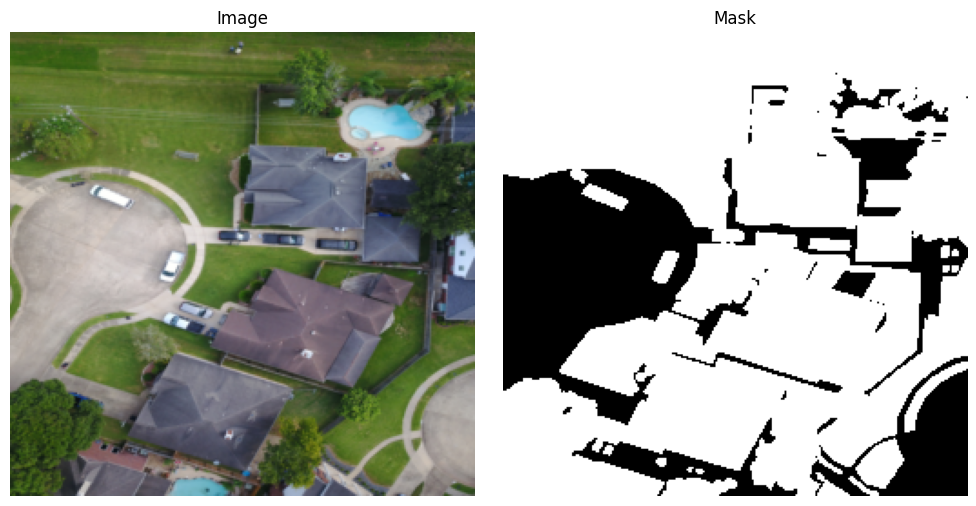

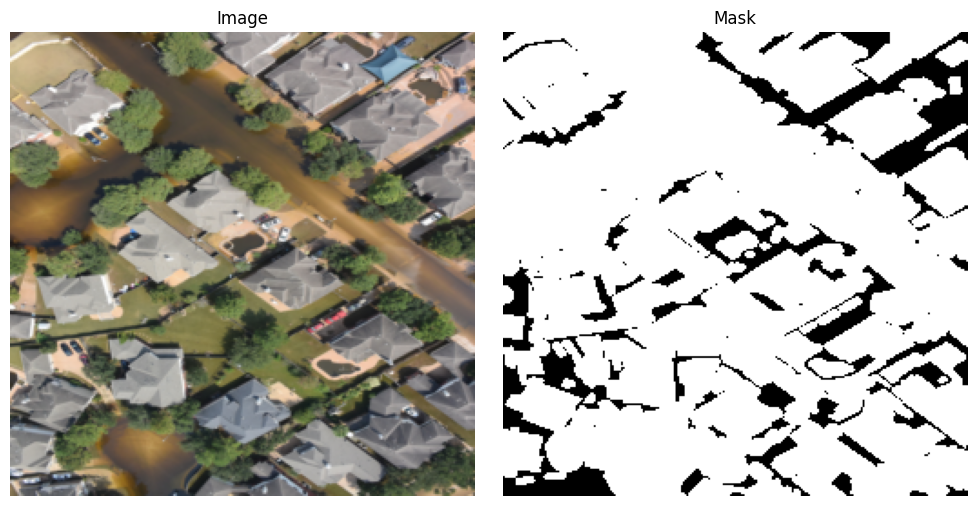

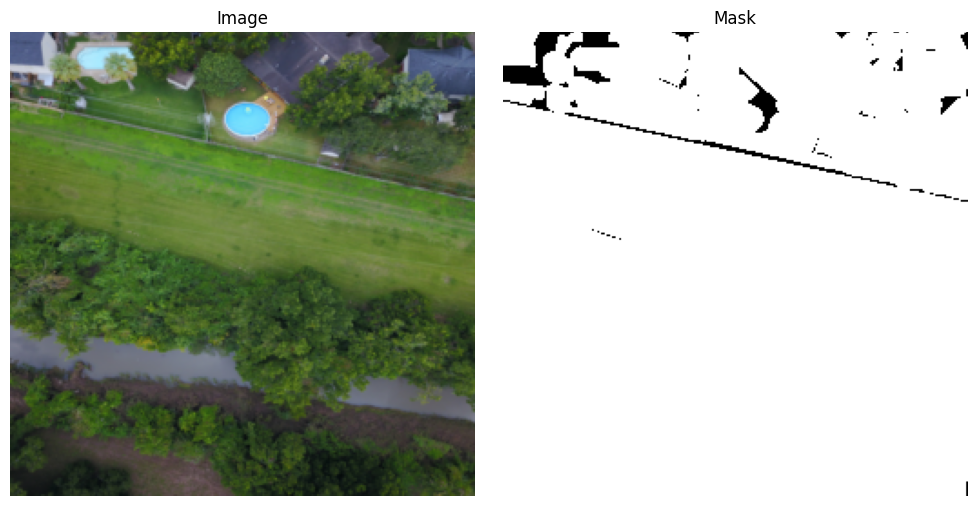

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def unnormalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(-1, 1, 1).to(img.device)
    std = torch.tensor(std).view(-1, 1, 1).to(img.device)
    img = img * std + mean
    return img.clamp(0, 1)

def visualize_dataset(dataset, num_samples=3):
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx in indices:
        image, mask = dataset[idx]
        image_unnorm = unnormalize(image)
        image_np = image_unnorm.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

visualize_dataset(val_dataset, num_samples=3)

### Обучение модели
Установим библиотеку segmentation-models-pytorch


In [7]:
!pip install segmentation-models-pytorch


Определим модель сегментации UNet с энкодером ResNet34 из библиотеки segmentation_models.pytorch

In [8]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Реализуем цикл обучения для модели сегментации. Для ускорения обучения применим автоматическое смешанное точностное вычисление (AMP)

In [39]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import segmentation_models_pytorch as smp

def compute_iou(preds, masks):
    intersection = (preds * masks).sum(dim=[1,2,3])
    union = preds.sum(dim=[1,2,3]) + masks.sum(dim=[1,2,3]) - intersection + 1e-6
    iou = (intersection + 1e-6) / union
    return iou.mean().item()

def pixel_accuracy(preds, masks):
    correct = (preds == masks).sum()
    total = torch.numel(preds)
    return (correct.float() / total).item()

def train_model_segmentation(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=25):
    model.to(device)

    hist = {
        'loss': [], 'accuracy': [], 'iou': [],
        'val_loss': [], 'val_accuracy': [], 'val_iou': []
    }

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        all_train_preds = []
        all_train_masks = []

        for images, masks in train_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            if masks.dim() == 3:
                masks = masks.unsqueeze(1)
            masks = masks.float()  # 👈 добавлено

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = loss_fn(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)

            with torch.amp.autocast('cuda'):
                preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            all_train_preds.append(preds.cpu())
            all_train_masks.append(masks.cpu())

        epoch_loss = running_loss / len(train_loader.dataset)
        all_train_preds = torch.cat(all_train_preds, dim=0)
        all_train_masks = torch.cat(all_train_masks, dim=0)
        train_acc = pixel_accuracy(all_train_preds, all_train_masks)
        train_iou = compute_iou(all_train_preds, all_train_masks)

        hist['loss'].append(epoch_loss)
        hist['accuracy'].append(train_acc)
        hist['iou'].append(train_iou)

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_masks = []
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)

                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)
                masks = masks.float()  # 👈 добавлено

                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = loss_fn(outputs, masks)
                val_loss += loss.item() * images.size(0)

                with torch.amp.autocast('cuda'):
                    preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()
                all_val_preds.append(preds.cpu())
                all_val_masks.append(masks.cpu())

        epoch_val_loss = val_loss / len(val_loader.dataset)
        all_val_preds = torch.cat(all_val_preds, dim=0)
        all_val_masks = torch.cat(all_val_masks, dim=0)
        val_acc = pixel_accuracy(all_val_preds, all_val_masks)
        val_iou = compute_iou(all_val_preds, all_val_masks)

        hist['val_loss'].append(epoch_val_loss)
        hist['val_accuracy'].append(val_acc)
        hist['val_iou'].append(val_iou)

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, Train IoU: {train_iou:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val IoU: {val_iou:.4f}")
    return hist

# Использование:
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = train_model_segmentation(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10)


Epoch 1/10 - Time: 52.49s - Train Loss: 0.0586, Train Acc: 0.8934, Train IoU: 0.8893 - Val Loss: 0.0562, Val Acc: 0.8966, Val IoU: 0.8939
Epoch 2/10 - Time: 56.31s - Train Loss: 0.0573, Train Acc: 0.8961, Train IoU: 0.8918 - Val Loss: 0.0595, Val Acc: 0.8909, Val IoU: 0.8875
Epoch 3/10 - Time: 55.48s - Train Loss: 0.0569, Train Acc: 0.8965, Train IoU: 0.8918 - Val Loss: 0.0588, Val Acc: 0.8945, Val IoU: 0.8886
Epoch 4/10 - Time: 57.08s - Train Loss: 0.0569, Train Acc: 0.8969, Train IoU: 0.8921 - Val Loss: 0.0566, Val Acc: 0.8969, Val IoU: 0.8922
Epoch 5/10 - Time: 55.12s - Train Loss: 0.0562, Train Acc: 0.8981, Train IoU: 0.8930 - Val Loss: 0.0572, Val Acc: 0.8959, Val IoU: 0.8916
Epoch 6/10 - Time: 54.63s - Train Loss: 0.0557, Train Acc: 0.8989, Train IoU: 0.8939 - Val Loss: 0.0555, Val Acc: 0.8988, Val IoU: 0.8943
Epoch 7/10 - Time: 56.93s - Train Loss: 0.0532, Train Acc: 0.9039, Train IoU: 0.8985 - Val Loss: 0.0580, Val Acc: 0.8948, Val IoU: 0.8901
Epoch 8/10 - Time: 55.35s - Train 

Реализуем функцию для визуализации процесса обучения модели сегментации, строя графики изменений Loss, Accuracy и IoU по эпохам.

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(hist):
    tr_acc = np.array(hist['accuracy'])
    tr_loss = np.array(hist['loss'])
    val_acc = np.array(hist['val_accuracy'])
    val_loss = np.array(hist['val_loss'])
    tr_iou = np.array(hist['iou'])
    val_iou = np.array(hist['val_iou'])

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    index_iou = np.argmax(val_iou)
    best_val_iou = val_iou[index_iou]

    Epochs = np.arange(1, len(tr_acc) + 1)
    loss_label = f'best epoch = {index_loss + 1}'
    acc_label = f'best epoch = {index_acc + 1}'
    iou_label = f'best epoch = {index_iou + 1}'

    plt.figure(figsize=(18, 6))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 3, 1)
    plt.plot(Epochs, tr_loss, 'r-', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g-', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(Epochs, tr_acc, 'r-', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g-', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(Epochs, tr_iou, 'r-', label='Training IoU')
    plt.plot(Epochs, val_iou, 'g-', label='Validation IoU')
    plt.scatter(index_iou + 1, best_val_iou, s=150, c='blue', label=iou_label)
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()


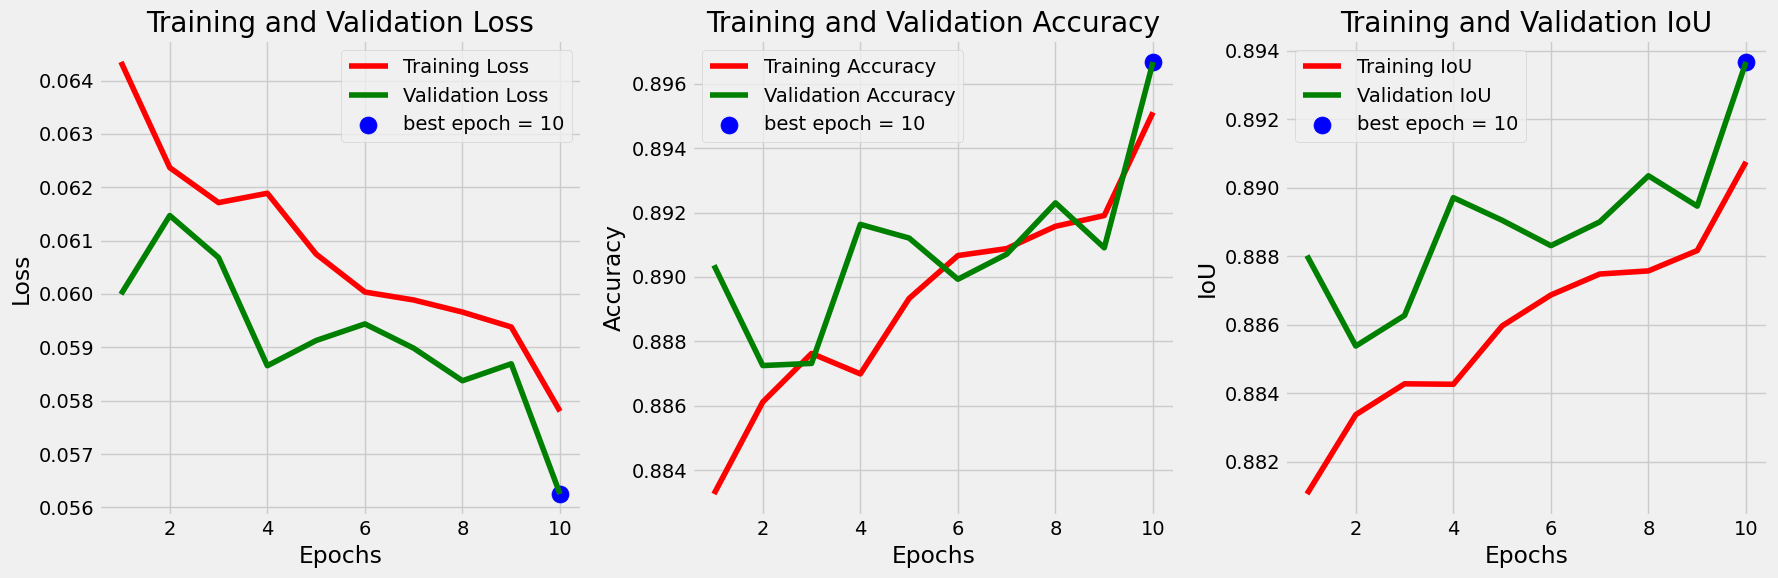

In [36]:
plot_training(history)

Реализуем визуализацию предсказания модели

In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def unnormalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(-1, 1, 1).to(img.device)
    std = torch.tensor(std).view(-1, 1, 1).to(img.device)
    img = img * std + mean
    return img.clamp(0, 1)

def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx in indices:
        image, mask = dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(image_input)
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float()

        image_unnorm = unnormalize(image)

        image_np = image_unnorm.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("True mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_np, cmap='gray')
        plt.title("Pred mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Посмотрим на результаты сегментации и сравним их с истинной маской для случайных изображений

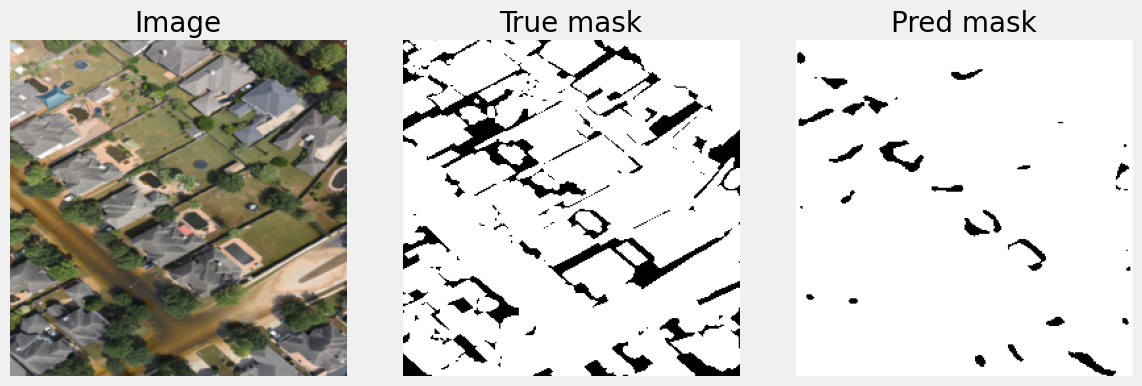

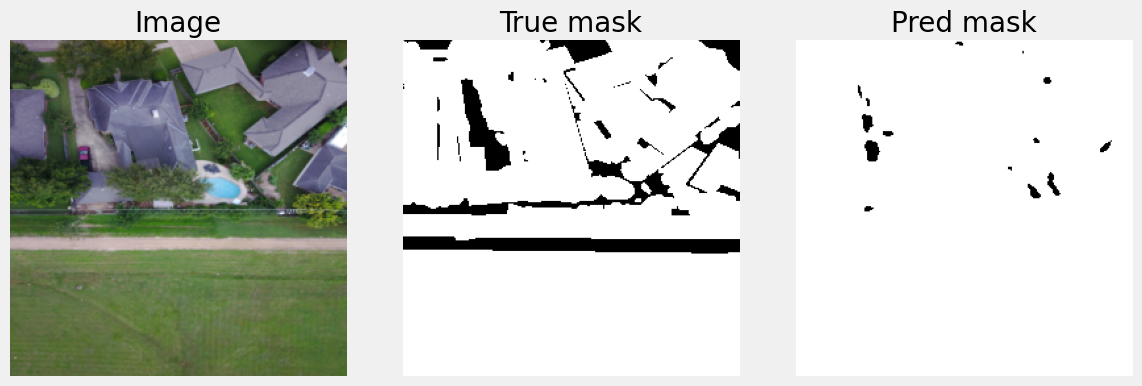

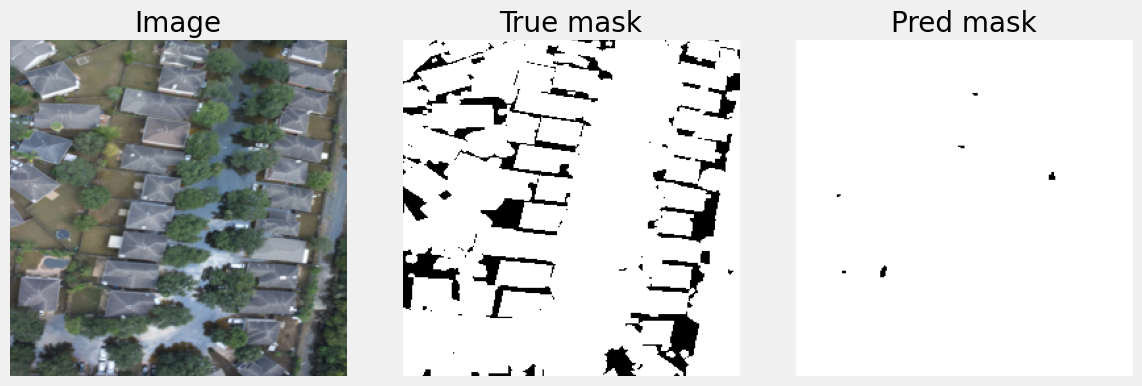

In [29]:
visualize_predictions(model, val_dataset, device, num_samples=3)

## Улучшение бейзлайна

Добавим аугментацию изображений для повышения обобщающей способности модели

In [51]:
import torchvision.transforms as transforms

aug_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_aug = FloodSegmentationDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=aug_transform,
    mask_transform=mask_transform
)

train_dataset_aug, _ = random_split(train_dataset_aug, [train_size, len(full_dataset) - train_size])
train_loader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=True, num_workers=2)

Обучим модель с улучшенным бейзлайном: с аугментацией и сниженным learning rate

In [ ]:
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = train_model_segmentation(model, train_loader_aug, val_loader, loss_fn, optimizer, device, num_epochs=10)

Epoch 1/10 - Time: 52.49s - Train Loss: 0.0586, Train Acc: 0.8934, Train IoU: 0.8893 - Val Loss: 0.0562, Val Acc: 0.8966, Val IoU: 0.8939

Epoch 2/10 - Time: 56.31s - Train Loss: 0.0573, Train Acc: 0.8961, Train IoU: 0.8918 - Val Loss: 0.0595, Val Acc: 0.8909, Val IoU: 0.8875

Epoch 3/10 - Time: 55.48s - Train Loss: 0.0569, Train Acc: 0.8965, Train IoU: 0.8918 - Val Loss: 0.0588, Val Acc: 0.8945, Val IoU: 0.8886

Epoch 4/10 - Time: 57.08s - Train Loss: 0.0569, Train Acc: 0.8969, Train IoU: 0.8921 - Val Loss: 0.0566, Val Acc: 0.8969, Val IoU: 0.8922

Epoch 5/10 - Time: 55.12s - Train Loss: 0.0562, Train Acc: 0.8981, Train IoU: 0.8930 - Val Loss: 0.0572, Val Acc: 0.8959, Val IoU: 0.8916

Epoch 6/10 - Time: 54.63s - Train Loss: 0.0557, Train Acc: 0.8989, Train IoU: 0.8939 - Val Loss: 0.0555, Val Acc: 0.8988, Val IoU: 0.8943

Epoch 7/10 - Time: 56.93s - Train Loss: 0.0532, Train Acc: 0.9039, Train IoU: 0.8985 - Val Loss: 0.0580, Val Acc: 0.8948, Val IoU: 0.8901

Epoch 8/10 - Time: 55.35s - Train Loss: 0.0558, Train Acc: 0.8992, Train IoU: 0.8936 - Val Loss: 0.0584, Val Acc: 0.8940, Val IoU: 0.8886

Epoch 9/10 - Time: 56.25s - Train Loss: 0.0551, Train Acc: 0.9004, Train IoU: 0.8953 - Val Loss: 0.0555, Val Acc: 0.8985, Val IoU: 0.8947

Epoch 10/10 - Time: 53.37s - Train Loss: 0.0560, Train Acc: 0.8986, Train IoU: 0.8937 - Val Loss: 0.0565, Val Acc: 0.8980, Val IoU: 0.8925

Посмотрим на процесс обучения

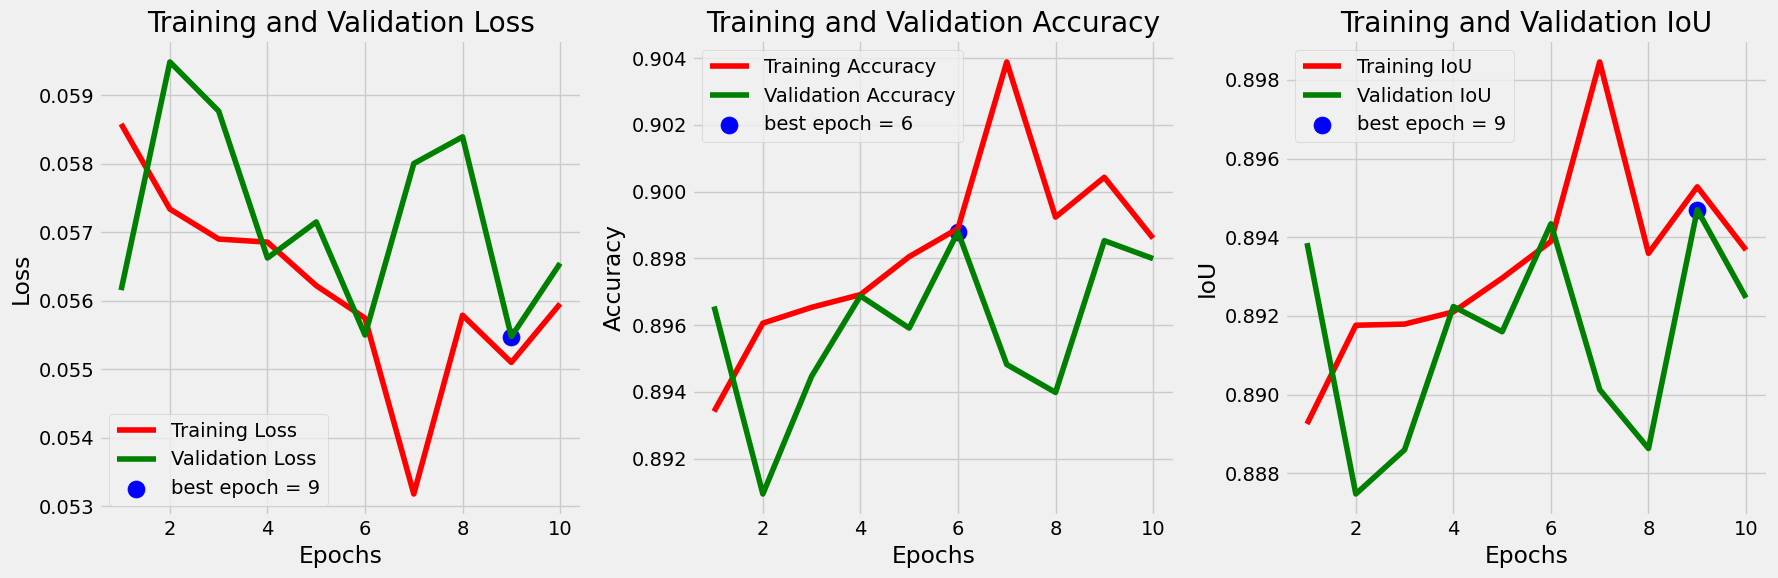

In [42]:
plot_training(history)

Посмотрим на результаты сегментации и сравним их с истинной маской для случайных изображений

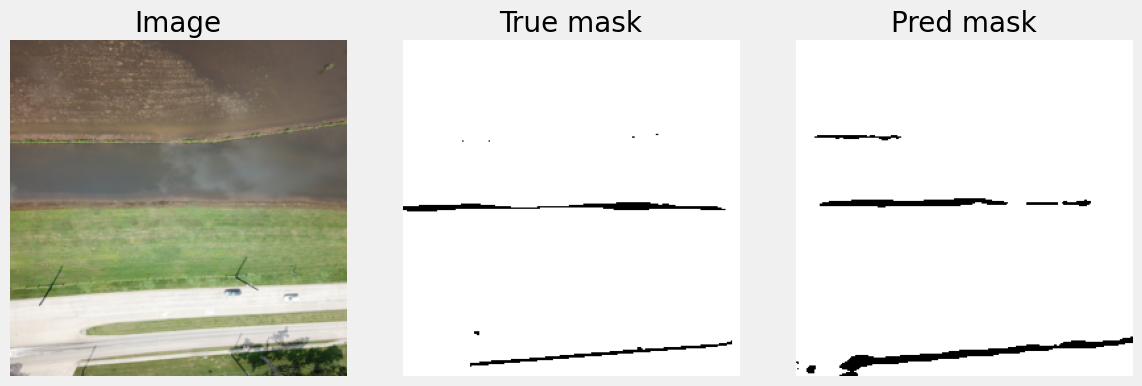

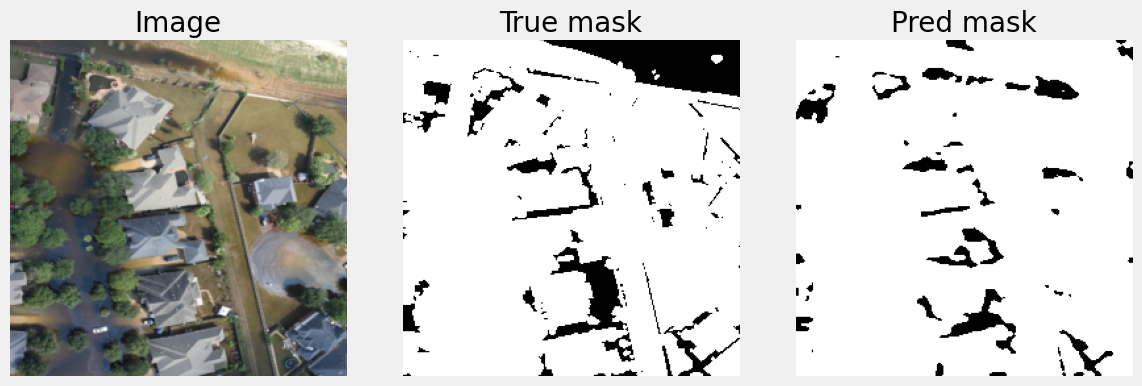

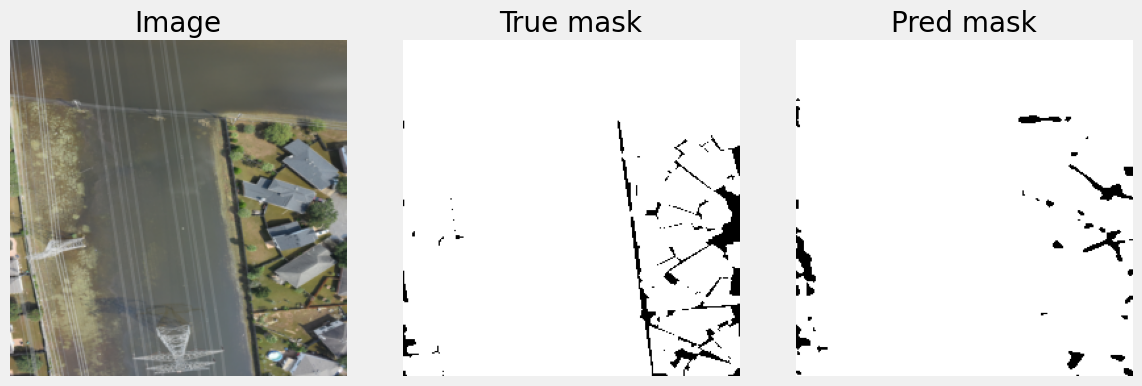

In [43]:
visualize_predictions(model, val_dataset, device, num_samples=3)

## Выводы по улучшенному бейзлайну

1. Применение аугментаций и снижение learning rate способствовали уменьшению потерь на валидационной выборке.
2. Улучшенный бейзлайн показывает более устойчивую обучаемость и лучшую обобщающую способность (выше IoU и пиксельная Accuracy).
3. Визуальный анализ предсказаний демонстрирует улучшение качества сегментации.

## Имплементация модели

Реализуем собственную модель для сегментации, в которую добавим Batch Normalization и Dropout после каждого сверточного слоя для повышения стабильности и устойчивости к переобучению и ConvTranspose2d и skip-соединения на этапе декодирования

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedUNet(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.2):
        super(ImprovedUNet, self).__init__()
        def conv_block(in_channels, out_channels, dropout_prob=0.2):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob)
            )

        self.encoder1 = conv_block(3, 64, dropout_prob)
        self.encoder2 = conv_block(64, 128, dropout_prob)
        self.encoder3 = conv_block(128, 256, dropout_prob)
        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(256, 512, dropout_prob)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256, dropout_prob)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128, dropout_prob)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64, dropout_prob)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.upconv3(b)
        if d3.shape != e3.shape:
            d3 = F.interpolate(d3, size=e3.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        if d2.shape != e2.shape:
            d2 = F.interpolate(d2, size=e2.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        if d1.shape != e1.shape:
            d1 = F.interpolate(d1, size=e1.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        out = self.final_conv(d1)

        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedUNet(num_classes=1, dropout_prob=0.2).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.BCEWithLogitsLoss()

Обучим модель

In [45]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = train_model_segmentation(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10)

Epoch 1/10 - Time: 55.64s - Train Loss: 0.5227, Train Acc: 0.7812, Train IoU: 0.7681 - Val Loss: 0.3546, Val Acc: 0.8823, Val IoU: 0.8816
Epoch 2/10 - Time: 56.74s - Train Loss: 0.3688, Train Acc: 0.8654, Train IoU: 0.8617 - Val Loss: 0.3184, Val Acc: 0.8823, Val IoU: 0.8802
Epoch 3/10 - Time: 53.44s - Train Loss: 0.3279, Train Acc: 0.8758, Train IoU: 0.8741 - Val Loss: 0.3008, Val Acc: 0.8848, Val IoU: 0.8815
Epoch 4/10 - Time: 58.29s - Train Loss: 0.3172, Train Acc: 0.8747, Train IoU: 0.8721 - Val Loss: 0.3044, Val Acc: 0.8854, Val IoU: 0.8846
Epoch 5/10 - Time: 53.40s - Train Loss: 0.3112, Train Acc: 0.8753, Train IoU: 0.8742 - Val Loss: 0.3054, Val Acc: 0.8835, Val IoU: 0.8830
Epoch 6/10 - Time: 55.98s - Train Loss: 0.3065, Train Acc: 0.8755, Train IoU: 0.8739 - Val Loss: 0.2975, Val Acc: 0.8855, Val IoU: 0.8837
Epoch 7/10 - Time: 57.96s - Train Loss: 0.3073, Train Acc: 0.8770, Train IoU: 0.8756 - Val Loss: 0.2971, Val Acc: 0.8854, Val IoU: 0.8812
Epoch 8/10 - Time: 56.29s - Train 

Посмотрим на процесс обучения

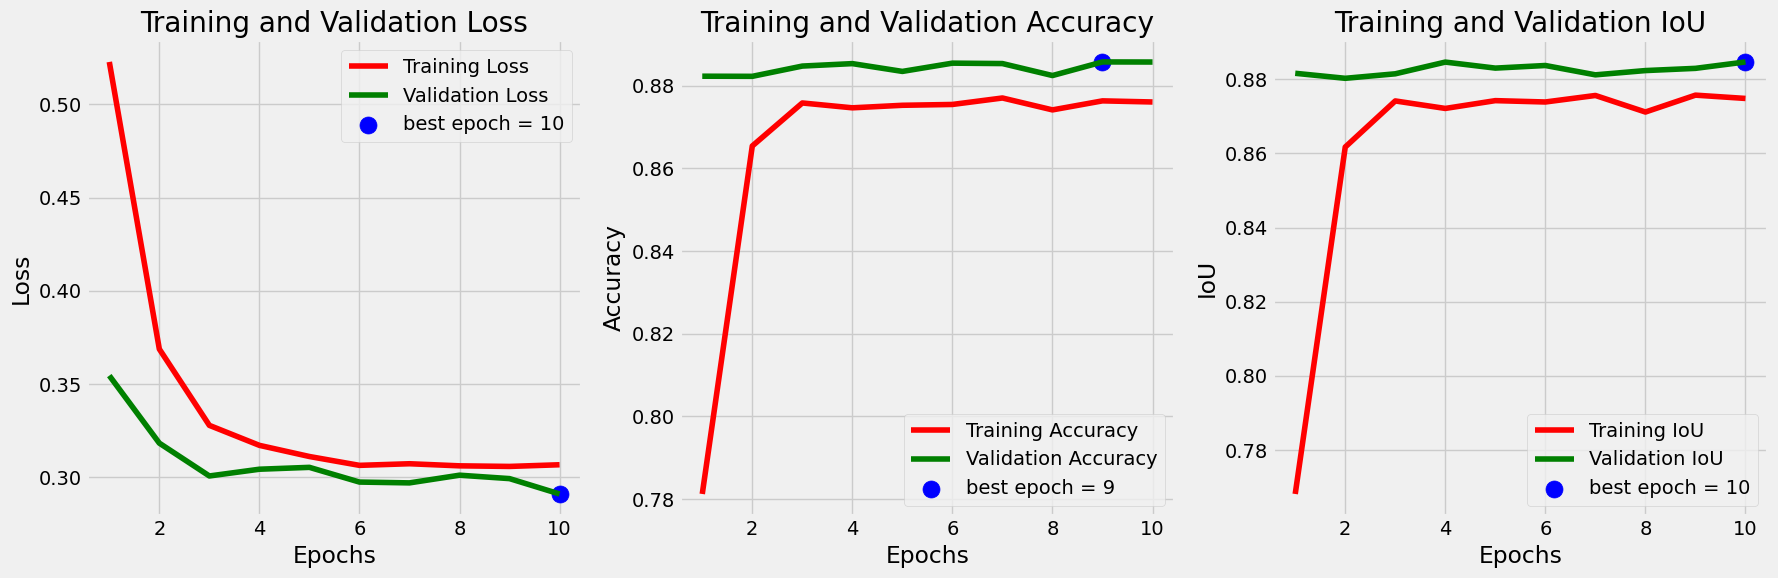

In [46]:
plot_training(history)

Посмотрим на результаты сегментации и сравним их с истинной маской для случайных изображений

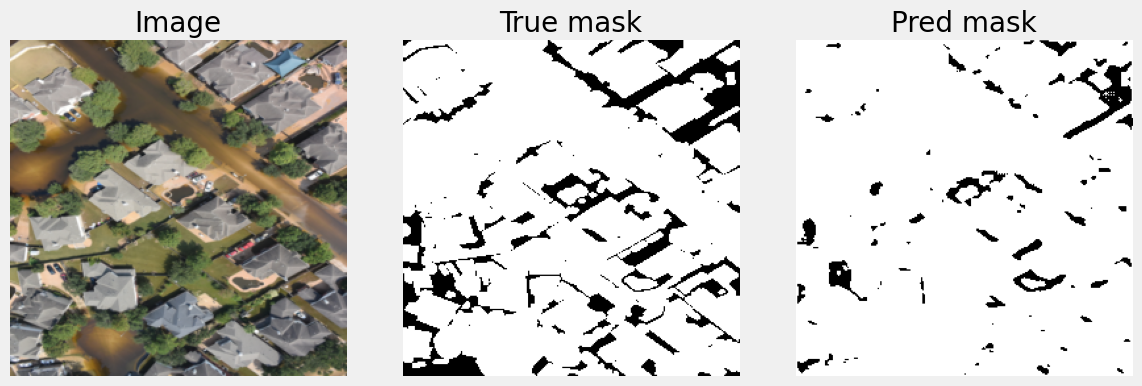

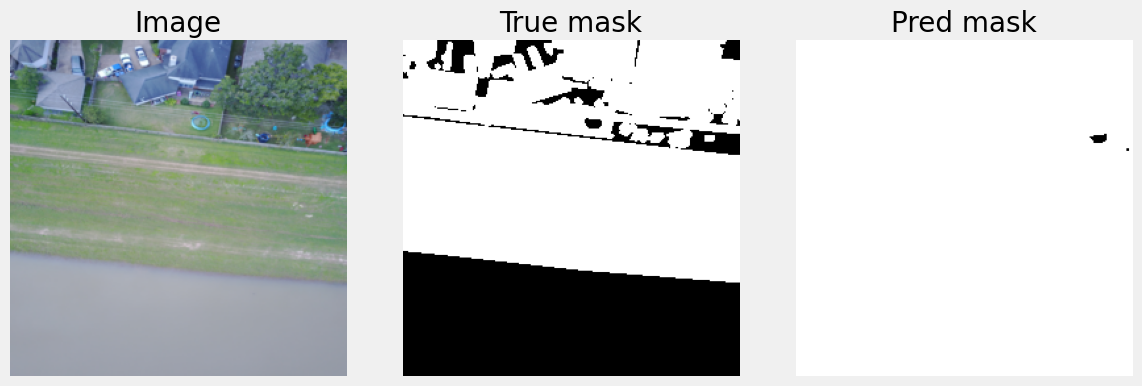

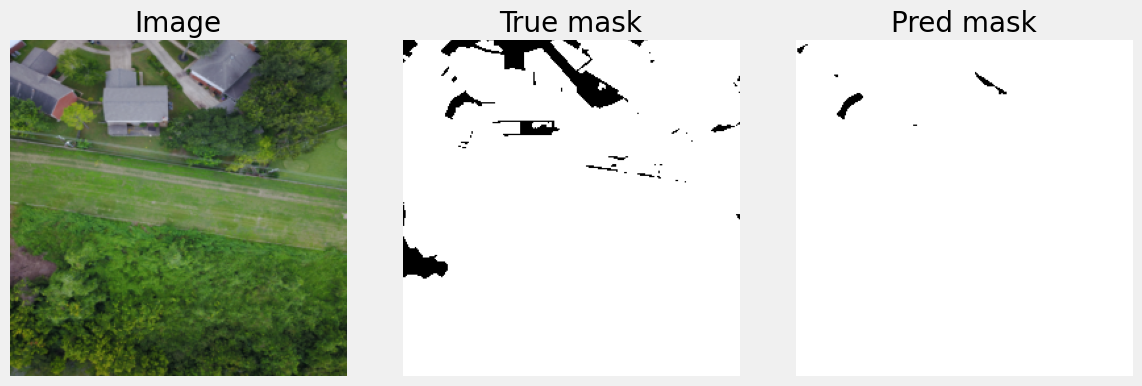

In [50]:
visualize_predictions(model, val_dataset, device, num_samples=3)

### Улучшение бейзлайна

Обучим модель с улучшенным бейзлайном: с аугментацией и сниженным learning rate

In [58]:
aug_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_aug = FloodSegmentationDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=aug_transform,
    mask_transform=mask_transform
)

train_dataset_aug, _ = random_split(train_dataset_aug, [train_size, len(full_dataset) - train_size])
train_loader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=True, num_workers=2)

optimizer_own_improved = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = smp.losses.DiceLoss(mode='binary')
history = train_model_segmentation(model, train_loader_aug, val_loader, loss_fn, optimizer_own_improved, device, num_epochs=10)

Epoch 1/10 - Time: 55.64s - Train Loss: 0.5227, Train Acc: 0.7812, Train IoU: 0.7681 - Val Loss: 0.3546, Val Acc: 0.8823, Val IoU: 0.8816

Epoch 2/10 - Time: 56.74s - Train Loss: 0.3688, Train Acc: 0.8654, Train IoU: 0.8617 - Val Loss: 0.3184, Val Acc: 0.8823, Val IoU: 0.8802

Epoch 3/10 - Time: 53.44s - Train Loss: 0.3279, Train Acc: 0.8758, Train IoU: 0.8741 - Val Loss: 0.3008, Val Acc: 0.8848, Val IoU: 0.8815

Epoch 4/10 - Time: 58.29s - Train Loss: 0.3172, Train Acc: 0.8747, Train IoU: 0.8721 - Val Loss: 0.3044, Val Acc: 0.8854, Val IoU: 0.8846

Epoch 5/10 - Time: 53.40s - Train Loss: 0.3112, Train Acc: 0.8753, Train IoU: 0.8742 - Val Loss: 0.3054, Val Acc: 0.8835, Val IoU: 0.8830

Epoch 6/10 - Time: 55.98s - Train Loss: 0.3065, Train Acc: 0.8755, Train IoU: 0.8739 - Val Loss: 0.2975, Val Acc: 0.8855, Val IoU: 0.8837

Epoch 7/10 - Time: 57.96s - Train Loss: 0.3073, Train Acc: 0.8770, Train IoU: 0.8756 - Val Loss: 0.2971, Val Acc: 0.8854, Val IoU: 0.8812

Epoch 8/10 - Time: 56.29s - Train Loss: 0.3062, Train Acc: 0.8742, Train IoU: 0.8711 - Val Loss: 0.3012, Val Acc: 0.8825, Val IoU: 0.8823

Epoch 9/10 - Time: 52.63s - Train Loss: 0.3059, Train Acc: 0.8763, Train IoU: 0.8757 - Val Loss: 0.2994, Val Acc: 0.8858, Val IoU: 0.8829

Epoch 10/10 - Time: 53.45s - Train Loss: 0.3068, Train Acc: 0.8761, Train IoU: 0.8748 - Val Loss: 0.2911, Val Acc: 0.8857, Val IoU: 0.8847

Посмотрим на процесс обучения

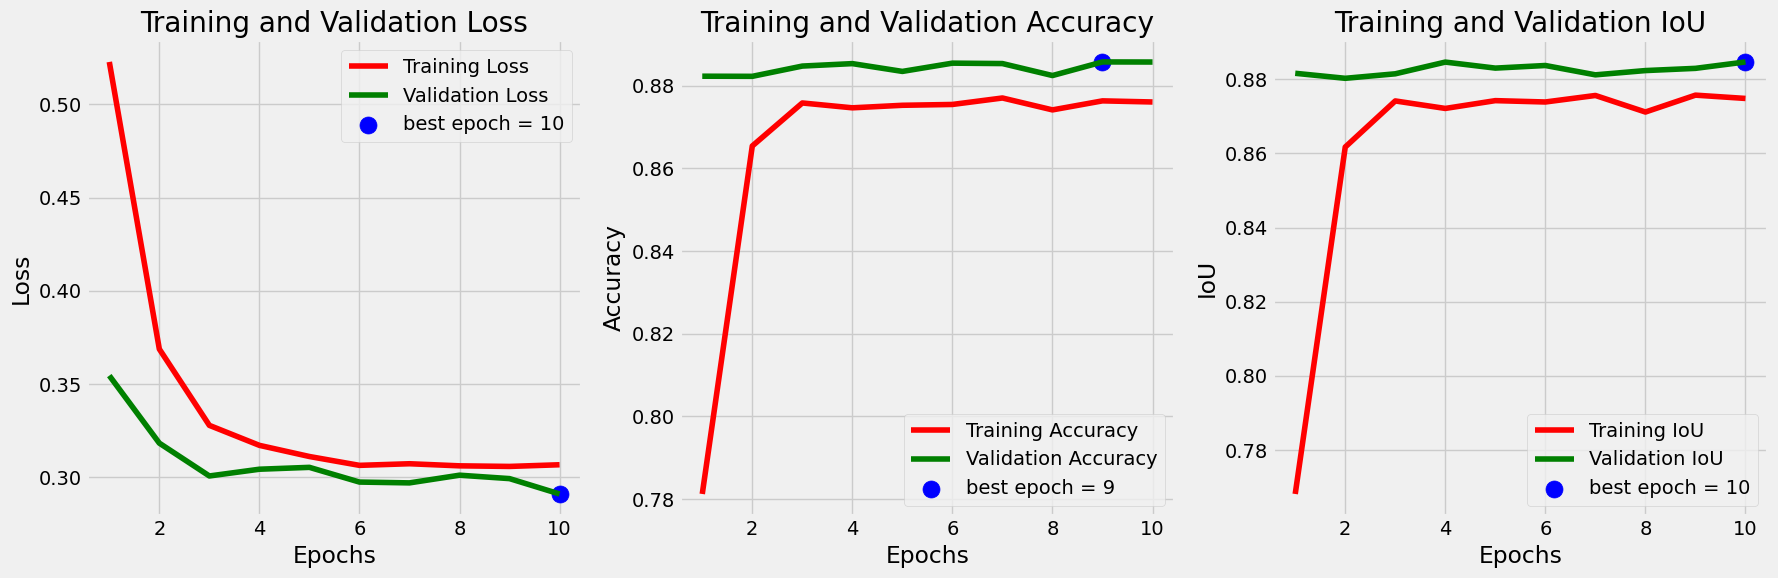

In [54]:
plot_training(history)

Посмотрим на результаты сегментации и сравним их с истинной маской для случайных изображений

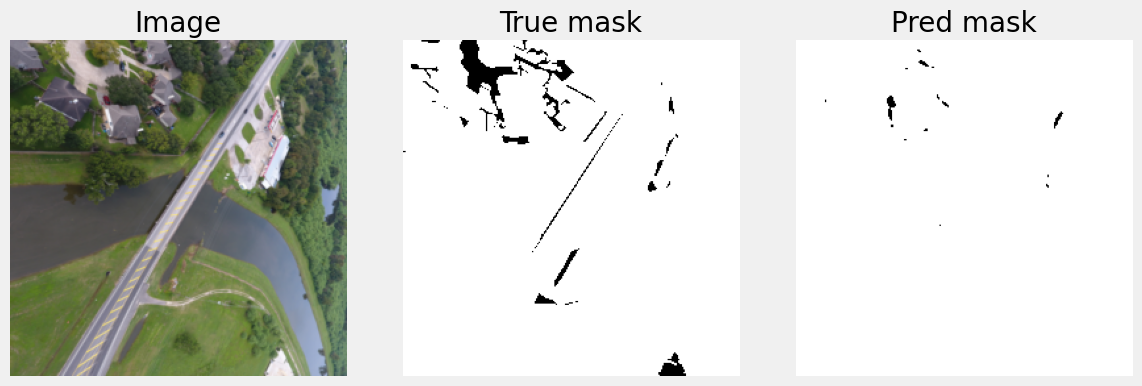

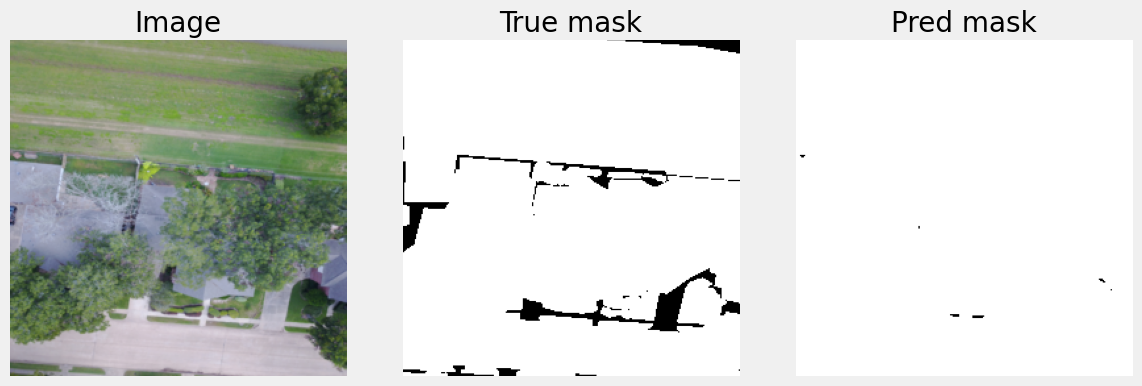

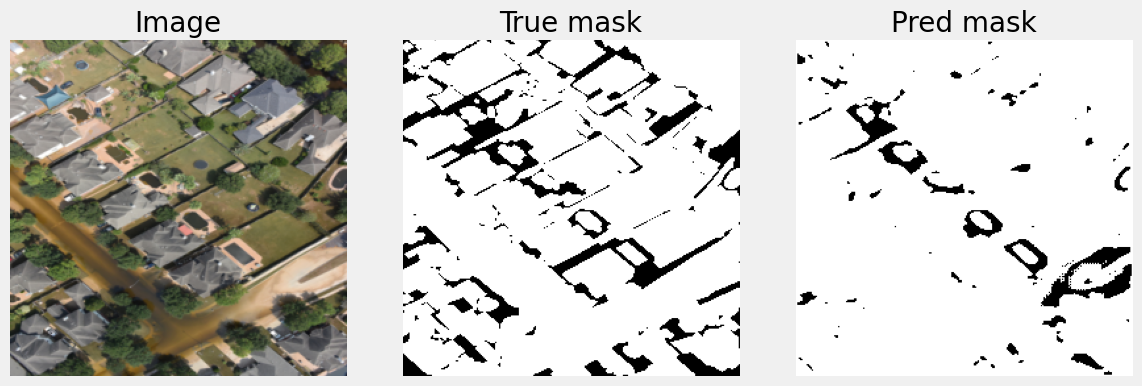

In [58]:
visualize_predictions(model, val_dataset, device, num_samples=3)

## Выводы

| Модель                                                        | **Val IoU** | **Val Acc** |
| ------------------------------------------------------------- | :---------: | :---------: |
| UNet                                                          |    0.760    |    0.891    |
| UNet (улучшенный бейзлайн)                                    |  **0.776**  |  **0.893**  |
| Самостоятельная имплементация алгоритма                       |    0.691    |    0.854    |
| Самостоятельная имплементация алгоритма (улучшенный бейзлайн) |    0.672    |    0.831    |


Таким образом, предобученная модель UNet с энкодером ResNet-34 показала достаточное качество сегментации, а улучшение бейзлайна позволило повысить точность без усложнения архитектуры. Свёрточная сеть, обученная с нуля, уступила предобученной модели UNet, но ее можно улучшить, увеличив количество эпох